In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
space = ExpressionSpace.from_config(get_path('configs', 'v7.0', 'expression_space.yaml'))

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [
    # 'pysr',
    # 'nesymres-100M',
    # 'v7.0',
    # 'v7.0-mini',
    # 'v7.11',
    # 'analysis_beams_v7.0/v7.0_512-beams'
    # 'v7.1',
    # 'v7.2',
    # 'v7.3',
    # 'v7.4',
    # 'v7.5',
    # 'v7.7',
    # 'v7.10',
    # 'v7.11',
    # 'v7.12',
    'v7.20',
    'v7.20.1',
    # 'v8.0',
    # 'v8.1',
    # 'v9.0',
    # 'v9.1',
]

REFERENCE_MODEL = 'v7.20'

MODELS_DESCRIPTION = {
    'nesymres-100M': 'NeSymReS 100M',
    'pysr': 'PySR',
}

for model in MODELS:
    if model not in MODELS_DESCRIPTION:
        MODELS_DESCRIPTION[model] = model

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}
TEST_SET_TITLES_LONG = {
    'train': 'Train',
    'val': 'Validation',
    'feynman': 'Feynman',
    'soose_nc': 'SOOSE-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val'])

            for k in keys_to_remove:
                if k in test_set_results['data']:
                    del test_set_results['data'][k]

Loading v7.20.1 results: 100%|██████████| 6/6 [02:02<00:00, 20.42s/it]


In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            if 'beam_search_time' in data:
                results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
                results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            elif 'fit_time' in data:
                results[model][test_set]['data']['wall_time'] = data['fit_time']
                results[model][test_set]['data']['sys_time'] = data['fit_time']

100%|██████████| 6/6 [00:00<00:00, 100663.30it/s]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']
        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])

        for j in range(beam_width):
            if f'free_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) if data[f'free_beam_{j + 1}'][i] is not None else None for i in range(len(data[f'free_beam_{j + 1}']))])
            if f'residuals_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
            if f'log_prob_beam{j + 1}' in data:
                results[model][test_set]['data'][f'log_prob_beam_{j + 1}'] = results[model][test_set]['data'][f'log_prob_beam{j + 1}']
                del results[model][test_set]['data'][f'log_prob_beam{j + 1}']
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 34.45it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 6/6 [00:01<00:00,  4.63it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'fit_time',  'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam', 'y_noisy'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'log_prob_best_beam',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structu

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
    'log_prob_best_beam': -np.inf,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

In [19]:
N_BOOTSTRAPS = 1_000

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

v7.20 train:  30%|██▉       | 14/47 [00:05<00:12,  2.66it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
v7.20.1 pool_15: 100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


In [21]:
def ar_test(data1, data2, test_statistic, n):
    # Compute the observed test statistic.
    obs_stat = test_statistic(data1, data2)

    # Pool the data from both samples.
    pooled_data = np.concatenate((data1, data2))
    n1 = len(data1)
    
    # Count the number of times the permuted statistic is at least as extreme as the observed.
    extreme_count = 0
    for _ in range(n):
        # Permute the pooled data.
        permuted = np.random.permutation(pooled_data)
        # Split into two groups (using the original sample sizes).
        perm_group1 = permuted[:n1]
        perm_group2 = permuted[n1:]
        # Compute the test statistic for the permutation.
        perm_stat = test_statistic(perm_group1, perm_group2)
        # For a two-sided test: count if the absolute value is at least as extreme.
        if abs(perm_stat) >= abs(obs_stat):
            extreme_count += 1
    
    # Compute the p-value (with a small correction to avoid a zero p-value).
    p_value = (extreme_count) / (n)
    
    return obs_stat, p_value

In [23]:
ar_p = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

reference_model = REFERENCE_MODEL

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                if column not in array_dfs[reference_model][test_set].columns:
                    ar_p[model][test_set][column] = {k: (np.nan, ) * 2 for k in sub_metrics}
                else:
                    ar_p[model][test_set][column] = {m: ar_test(array_dfs[reference_model][test_set][column], data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                ar_p[model][test_set][column] = {k: (np.nan, ) * 2 for k in sub_metrics}

            if metrics is None:
                metrics = ar_p[model][test_set][column].keys()

v7.20 train:  30%|██▉       | 14/47 [00:10<00:24,  1.34it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
v7.20 feynman:  30%|██▉       | 14/47 [00:10<00:24,  1.37it/s]/tmp/ipykernel_4895/2741934729.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  ar_p[model][test_set][column] = {m: ar_test(array_dfs[reference_model][test_set][column], data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
v7.20.1 pool_15: 100%|██████████| 47/47 [00:33<00:00,  1.40it/s]


In [24]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

In [25]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

ar_tables = {
    column: {
        metric: {
            value:
                pd.DataFrame({
                model: {
                    test_set: ar_p[model][test_set][column][metric][k]
                    for test_set in ar_p[model].keys()}
                    for model in ar_p.keys()}).T.round(3)
                    for k, value in enumerate(['statistic', 'p'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [26]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)"
v7.20.1,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [27]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.719 (0.706, 0.732)","0.725 (0.713, 0.737)","0.875 (0.865, 0.883)","0.803 (0.793, 0.815)","0.888 (0.879, 0.897)","0.616 (0.602, 0.628)"
v7.20.1,"0.729 (0.717, 0.742)","0.742 (0.731, 0.754)","0.892 (0.884, 0.901)","0.818 (0.807, 0.828)","0.92 (0.912, 0.927)","0.637 (0.624, 0.65)"


In [28]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.874 (0.864, 0.883)","0.883 (0.874, 0.891)","0.934 (0.927, 0.941)","0.862 (0.852, 0.871)","0.984 (0.98, 0.988)","0.808 (0.797, 0.819)"
v7.20.1,"0.883 (0.874, 0.892)","0.891 (0.882, 0.898)","0.942 (0.936, 0.949)","0.874 (0.865, 0.883)","0.988 (0.985, 0.991)","0.813 (0.802, 0.823)"


In [29]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.522 (0.509, 0.536)","0.547 (0.532, 0.56)","0.752 (0.74, 0.764)","0.7 (0.687, 0.712)","0.763 (0.751, 0.774)","0.36 (0.347, 0.374)"
v7.20.1,"0.539 (0.527, 0.552)","0.559 (0.545, 0.573)","0.78 (0.767, 0.791)","0.723 (0.71, 0.736)","0.797 (0.785, 0.808)","0.378 (0.365, 0.391)"


In [30]:
m = 'FVU-eps_accuracy'
sm = 'mean'
ar_tables[m][sm]['p']

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,0.082,0.221,0.0,0.007,0.0,0.073
v7.20.1,1.000,1.000,1.0,1.000,1.0,1.000


In [31]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.517 (0.503, 0.531)","0.539 (0.525, 0.553)","0.75 (0.738, 0.762)","0.699 (0.687, 0.712)","0.763 (0.752, 0.775)","0.356 (0.342, 0.368)"
v7.20.1,"0.536 (0.523, 0.55)","0.555 (0.542, 0.568)","0.778 (0.767, 0.79)","0.722 (0.71, 0.735)","0.797 (0.786, 0.807)","0.372 (0.359, 0.386)"


#### Numeric Error

In [32]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.177 (0.161, 0.193)","0.169 (0.156, 0.183)","0.175 (0.157, 0.195)","0.409 (0.383, 0.438)","0.016 (0.013, 0.02)","0.291 (0.185, 0.502)"
v7.20.1,"0.203 (0.157, 0.288)","0.173 (0.157, 0.188)","0.197 (0.174, 0.22)","0.425 (0.398, 0.453)","0.017 (0.012, 0.023)","0.429 (0.194, 0.845)"


In [33]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"27156.133 (522.728, 82803.896)","6.203095707213281e+129 (3591.382, 1.9212239847...","33.937 (8.81, 78.437)","749.965 (2.723, 2291.601)","0.017 (0.013, 0.021)","78232523937.192 (66.353, 237796040133.489)"
v7.20.1,"43423517606.208 (8.952, 171529260960.655)","4.337538182005507e+19 (40.124, 1.3683325616419...","152.606 (17.374, 370.073)","225.501 (23.709, 518.059)","0.018 (0.013, 0.023)","16851258590.086 (193616.03, 65779680615.048)"


In [34]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.728 (0.725, 0.73)","0.718 (0.716, 0.721)","0.693 (0.692, 0.694)","0.699 (0.698, 0.701)","0.688 (0.687, 0.69)","0.753 (0.748, 0.756)"
v7.20.1,"0.776 (0.774, 0.779)","0.772 (0.77, 0.775)","0.749 (0.748, 0.751)","0.746 (0.745, 0.748)","0.755 (0.754, 0.757)","0.824 (0.819, 0.829)"


In [35]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.728 (0.725, 0.73)","0.718 (0.716, 0.721)","0.693 (0.692, 0.694)","0.699 (0.698, 0.701)","0.688 (0.687, 0.69)","0.753 (0.748, 0.756)"
v7.20.1,"0.776 (0.774, 0.779)","0.772 (0.77, 0.775)","0.749 (0.748, 0.751)","0.746 (0.745, 0.748)","0.755 (0.754, 0.757)","0.824 (0.819, 0.829)"


In [36]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"5.976 (5.689, 6.321)","5.97 (5.695, 6.365)","12.932 (12.138, 13.985)","2.331 (2.259, 2.418)","5.532 (5.05, 6.081)","65.949 (58.866, 74.464)"
v7.20.1,"5.792 (5.437, 6.09)","5.562 (5.253, 5.925)","10.594 (9.743, 11.554)","2.113 (2.046, 2.176)","5.375 (4.752, 5.944)","59.488 (51.763, 67.282)"


In [37]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"16.261 (15.978, 16.548)","15.902 (15.62, 16.193)","12.035 (11.777, 12.304)","7.825 (7.589, 8.052)","11.787 (11.506, 12.092)","22.956 (22.62, 23.291)"
v7.20.1,"16.167 (15.865, 16.466)","15.702 (15.428, 15.973)","11.402 (11.143, 11.662)","7.443 (7.206, 7.674)","11.693 (11.402, 11.99)","22.943 (22.62, 23.275)"


In [38]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.857 (0.853, 0.861)","0.861 (0.857, 0.864)","0.891 (0.889, 0.894)","0.887 (0.883, 0.891)","0.815 (0.811, 0.82)","0.828 (0.825, 0.832)"
v7.20.1,"0.86 (0.856, 0.863)","0.862 (0.859, 0.866)","0.9 (0.897, 0.902)","0.894 (0.89, 0.898)","0.817 (0.812, 0.822)","0.829 (0.826, 0.832)"


In [39]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"0.626 (0.619, 0.632)","0.631 (0.625, 0.638)","0.68 (0.673, 0.687)","0.766 (0.759, 0.773)","0.648 (0.639, 0.657)","0.499 (0.492, 0.505)"
v7.20.1,"0.631 (0.624, 0.637)","0.635 (0.628, 0.641)","0.698 (0.692, 0.706)","0.781 (0.774, 0.788)","0.657 (0.649, 0.666)","0.499 (0.493, 0.504)"


In [40]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.20,"6.054 (5.947, 6.16)","5.949 (5.857, 6.05)","4.428 (4.347, 4.523)","2.911 (2.827, 3.002)","3.941 (3.836, 4.046)","9.061 (8.933, 9.191)"
v7.20.1,"6.019 (5.922, 6.108)","5.862 (5.759, 5.963)","4.182 (4.103, 4.272)","2.778 (2.702, 2.867)","3.858 (3.759, 3.959)","9.068 (8.932, 9.206)"


In [41]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=6, fmt_fn=None, factor=1, sem=True):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if sem:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
        upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)
    else:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column]['2.5p']['median'] * (-1 if negate else 1)
        upper_df = tables[column]['97.5p']['median'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ #[(${fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}$)] <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---').replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

In [42]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [43]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [#emoji.lightning v7.20], [*52.2\ #[($50.9$, $53.6$)] <table_CI>*], [*54.7\ #[($53.2$, $56.0$)] <table_CI>*], [75.2\ #[($74.0$, $76.4$)] <table_CI>], [*70.0\ #[($68.7$, $71.2$)] <table_CI>*], [76.3\ #[($75.1$, $77.4$)] <table_CI>], [*36.0\ #[($34.7$, $37.4$)] <table_CI>*],
  [#emoji.lightning v7.20.1], [*53.9\ #[($52.7$, $55.2$)] <table_CI>*], [*55.9\ #[($54.5$, $57.3$)] <table_CI>*], [*78.0\ #[($76.7$, $79.1$)] <table_CI>*], [*72.3\ #[($71.0$, $73.6$)] <table_CI>*], [*79.7\ #[($78.5$, $80.8$)] <table_CI>*], [*37.8\ #[($36.5$, $39.1$)] <table_CI>*],

    table.hline(),


In [44]:
# print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))

In [45]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [#emoji.lightning v7.20], [*6.05\ #[($5.95$, $6.16$)] <table_CI>*], [*5.95\ #[($5.86$, $6.05$)] <table_CI>*], [4.43\ #[($4.35$, $4.52$)] <table_CI>], [*2.91\ #[($2.83$, $3.00$)] <table_CI>*], [*3.94\ #[($3.84$, $4.05$)] <table_CI>*], [*9.06\ #[($8.93$, $9.19$)] <table_CI>*],
  [#emoji.lightning v7.20.1], [*6.02\ #[($5.92$, $6.11$)] <table_CI>*], [*5.86\ #[($5.76$, $5.96$)] <table_CI>*], [*4.18\ #[($4.10$, $4.27$)] <table_CI>*], [*2.78\ #[($2.70$, $2.87$)] <table_CI>*], [*3.86\ #[($3.76$, $3.96$)] <table_CI>*], [*9.07\ #[($8.93$, $9.21$)] <table_CI>*],

    table.hline()

# Length

In [46]:
data_lengths = {model: {test_set: None for test_set in TEST_SETS} for model in array_dfs.keys()}

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        if len(model_dfs) == 0:
            continue
        data_lengths[model][test_set] = {length: df[df['length_target'] == length] for length in range(32)}

KeyError: 'v7.0'

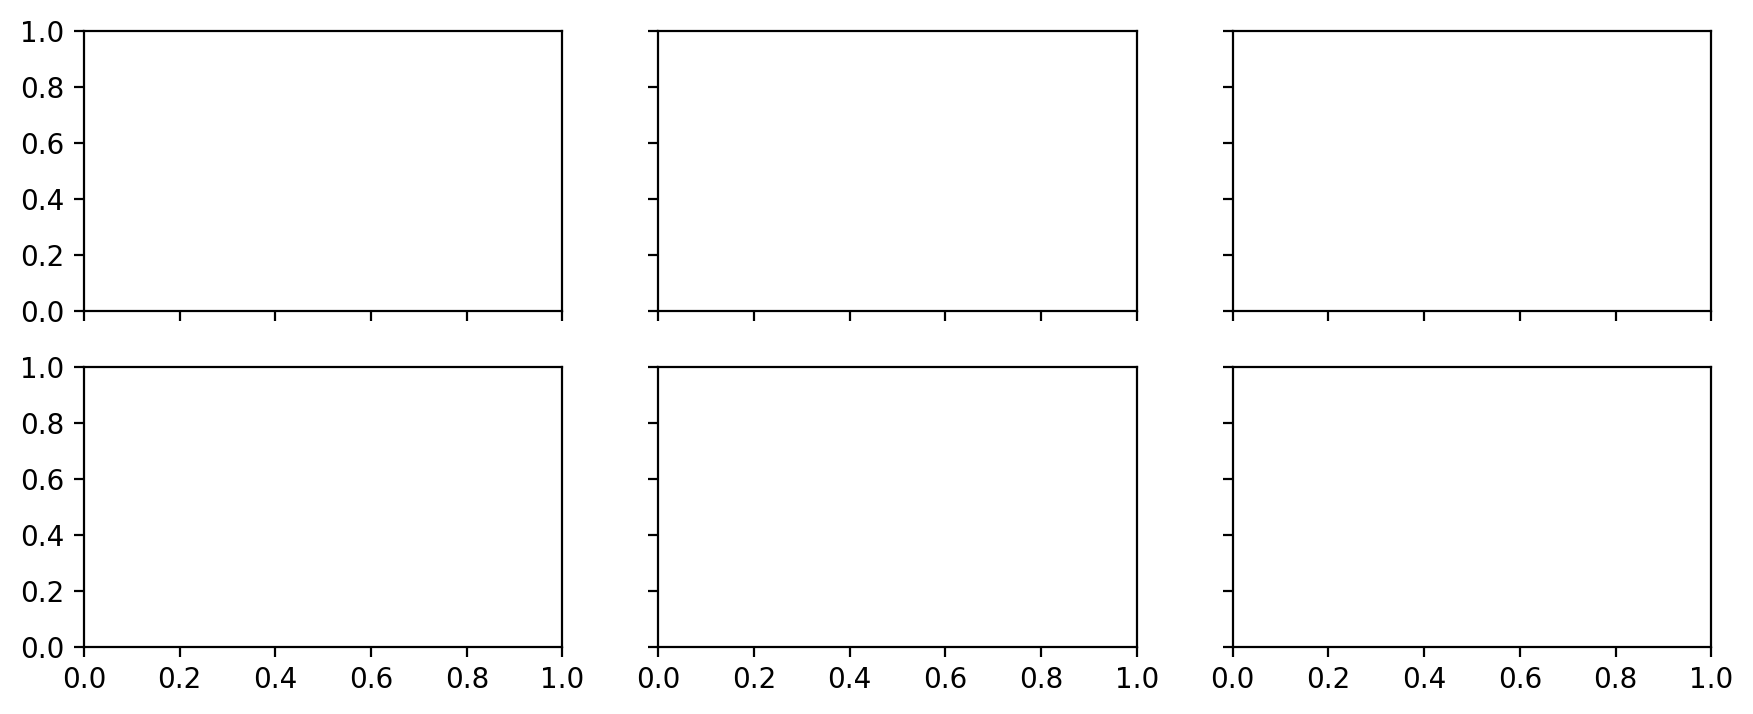

In [47]:
show_model = 'v7.0'
show_model_2 = 'v7.2'
metric = 'fvu'

COLS = 3
ROWS = 2

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2), dpi=200, sharex=True, sharey=True)


for i, (ax, test_set) in enumerate(zip(axes.flatten(), TEST_SETS)):
    ax.hist2d(
        array_dfs[show_model][test_set]['length_target'],
        np.log10(array_dfs[show_model][test_set]['fvu'] + np.finfo(np.float64).eps),
        bins=(np.arange(2, 33), np.linspace(-16, 1, 18)),
        cmap='viridis',
        rasterized=True)

    # Draw the median FVU for each length
    bootstraps = [bootstrapped_metric_ci(data_lengths[show_model][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
    median = [b[0] for b in bootstraps]
    lower = [b[1] for b in bootstraps]
    upper = [b[2] for b in bootstraps]

    valid_mask = ~np.isnan(median)

    index = np.arange(2, 32)[valid_mask]
    median = np.array(median)[valid_mask]
    lower = np.array(lower)[valid_mask]
    upper = np.array(upper)[valid_mask]

    ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='.', color='w', lw=0.5, label='v7.0 Median', zorder=2)
    ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='w', alpha=0.1, zorder=2)

    if show_model_2 in data_lengths and data_lengths[show_model_2][test_set] is not None:
        bootstraps = [bootstrapped_metric_ci(data_lengths[show_model_2][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
        median = [b[0] for b in bootstraps]
        lower = [b[1] for b in bootstraps]
        upper = [b[2] for b in bootstraps]

        valid_mask = ~np.isnan(median)

        index = np.arange(2, 32)[valid_mask]
        median = np.array(median)[valid_mask]
        lower = np.array(lower)[valid_mask]
        upper = np.array(upper)[valid_mask]

        ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='s', color='tab:orange', lw=0.5, label=f'{show_model_2} Median', zorder=1, markersize=2)
        ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='tab:orange', alpha=0.1, zorder=1)

    ax.grid(zorder=0, alpha=0.1)
    ax.annotate(f'{chr(ord("a") + i)}) {TEST_SET_TITLES_LONG[test_set]}', xy=(0.03, 0.93), xycoords='axes fraction', ha='left', va='top', color='w')
    if i % COLS == 0:
        ax.set_ylabel('$\\log_{10}(\\text{FVU} + \\epsilon_{64})$')
    if i >= (ROWS - 1) * COLS:
        ax.set_xlabel('Expression Length')

    ax.axhline(np.log10(np.finfo(np.float32).eps), color='w', lw=0.5, ls='--', alpha=0.3, zorder=1, label='$\\epsilon_{32} \\approx' + f'{np.finfo(np.float32).eps:.2e}$')

fig.tight_layout()

# Add a handle for the histogram
l = plt.Rectangle((0, 0), 0.5, 1, fc=plt.get_cmap('viridis')(0.95))

handles, labels = axes[0, 1].get_legend_handles_labels()
handles.insert(1, l)
labels.insert(1, 'v7.0 Density')

axes[1, 0].legend(framealpha=0.5, handles=handles, labels=labels, loc='upper right')

if 'v7.2' in data_lengths:
    plt.savefig(get_path('results', 'main', create=True, filename='fvu_length_heatmaps_comparison.svg'), bbox_inches='tight')

In [48]:
model = 'v7.0'
test_set = 'pool_15'
for i in range(10):
    print(f"L = {len(results[model][test_set]['data']['input_ids'][i][1:-1])}")
    print(f"{results[model][test_set]['data']['fvu'][i]:.2e}")
    print(space.tokenizer.decode(results[model][test_set]['data']['free_beam_1'][i]))
    print(space.tokenizer.decode(results[model][test_set]['data']['input_ids'][i])[1:-1])
    print()

KeyError: 'v7.0'

# Aggregated

In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

v7.20:  30%|██▉       | 14/47 [00:18<00:42,  1.28s/it]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
v7.20.1: 100%|██████████| 47/47 [01:00<00:00,  1.29s/it]


In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_ar_p = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']

reference_model = REFERENCE_MODEL
reference_aggregated_data = pd.concat([df for test_set, df in array_dfs[reference_model].items() if test_set in aggregate_sets])

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            if column not in reference_aggregated_data.columns:
                total_ar_p[model][column] = {k: (np.nan, ) * 2 for k in sub_metrics}
            else:
                reference_data = reference_aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                
                total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

v7.20:  30%|██▉       | 14/47 [00:32<01:17,  2.35s/it]/tmp/ipykernel_4895/3013933052.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
v7.20:  96%|█████████▌| 45/47 [01:43<00:04,  2.17s/it]

In [50]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [51]:
total_ar_tables = {
    metric: {
        value:
            pd.DataFrame({
            model: {
                column: total_ar_p[model][column][metric][k]
                for column in compare_columns}
                for model in total_ar_p.keys()}).T.round(3)
                for k, value in enumerate(['statistic', 'p'])}
                for metric in metrics}

In [52]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,v7.0,v8.0,v8.1
FVU-eps_accuracy,"0.645 (0.639, 0.652)","0.577 (0.57, 0.584)","0.649 (0.643, 0.655)"
FVU-eps_accuracy_val,"0.643 (0.637, 0.649)","0.575 (0.568, 0.582)","0.647 (0.639, 0.653)"
NSRTS_accuracy_close_best_beam,"0.808 (0.803, 0.813)","0.762 (0.756, 0.767)","0.809 (0.803, 0.814)"
NSRTS_accuracy_close_val_best_beam,"0.806 (0.801, 0.812)","0.762 (0.756, 0.768)","0.808 (0.802, 0.813)"
NSRTS_accuracy_r2_best_beam,"0.908 (0.904, 0.912)","0.88 (0.875, 0.884)","0.903 (0.899, 0.907)"
NSRTS_accuracy_r2_val_best_beam,"0.899 (0.895, 0.903)","0.869 (0.865, 0.874)","0.892 (0.887, 0.896)"
accuracy_best_beam,"0.261 (0.255, 0.267)","0.198 (0.193, 0.203)","0.252 (0.246, 0.258)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [53]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_ar_tables['mean']['p'].T.loc[columns].sort_index()

,v7.0,v8.0,v8.1
FVU-eps_accuracy,1.0,0.000,0.428
FVU-eps_accuracy_val,1.0,0.000,0.480
NSRTS_accuracy_close_best_beam,1.0,0.000,0.846
NSRTS_accuracy_close_val_best_beam,1.0,0.000,0.700
NSRTS_accuracy_r2_best_beam,1.0,0.000,0.078
NSRTS_accuracy_r2_val_best_beam,1.0,0.000,0.015
accuracy_best_beam,1.0,0.000,0.042
structural_accuracy_best_beam,1.0,0.227,0.625


In [54]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,v7.0,v8.0,v8.1
edit_distance_best_beam,"4.981 (4.918, 5.042)","5.421 (5.359, 5.479)","5.053 (4.99, 5.119)"
tree_edit_distance_best_beam,"13.271 (13.117, 13.441)","14.573 (14.411, 14.742)","13.366 (13.201, 13.522)"
f1_score_best_beam,"0.879 (0.877, 0.881)","0.84 (0.838, 0.842)","0.86 (0.858, 0.862)"
meteor_best_beam,"0.67 (0.666, 0.674)","0.631 (0.627, 0.635)","0.67 (0.666, 0.674)"
precision_best_beam,"0.896 (0.894, 0.898)","0.863 (0.861, 0.865)","0.879 (0.877, 0.88)"
bleu_best_beam,"0.44 (0.435, 0.446)","0.38 (0.375, 0.386)","0.435 (0.43, 0.44)"
recall_best_beam,"0.872 (0.87, 0.874)","0.832 (0.83, 0.835)","0.855 (0.853, 0.858)"
rougeL_recall_best_beam,"0.719 (0.716, 0.722)","0.687 (0.684, 0.689)","0.714 (0.711, 0.717)"
reciprocal_rank,"0.83 (0.828, 0.832)","0.798 (0.796, 0.8)","0.82 (0.818, 0.822)"
perplexity,"118740.534 (19646.188, 290884.374)","42675.879 (30319.606, 57595.468)","2552.447 (2085.687, 3147.48)"


In [55]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_ar_tables['mean']['p'].T.loc[columns]

,v7.0,v8.0,v8.1
edit_distance_best_beam,1.0,0.000,0.114
tree_edit_distance_best_beam,1.0,0.000,0.447
f1_score_best_beam,1.0,0.000,0.000
meteor_best_beam,1.0,0.000,0.810
precision_best_beam,1.0,0.000,0.000
bleu_best_beam,1.0,0.000,0.247
recall_best_beam,1.0,0.000,0.000
rougeL_recall_best_beam,1.0,0.000,0.024
reciprocal_rank,1.0,0.000,0.000
perplexity,1.0,0.470,0.000


## Complete Metrics

In [56]:
def summary_table_to_typst(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=6, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set

    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {{
            (right: (
            thickness: 0.5pt,
            ))
            }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning$thin$' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows(), ar_df.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [57]:
columns = ['is_finite', 'FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'edit_distance_best_beam', 'tree_edit_distance_best_beam', 'meteor_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Fit)] <table_CI>',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Val)] <table_CI>',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_1$] <table_CI>',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_2$] <table_CI>',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$ \ Symbolic Recovery Rate <table_CI>',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": f'$log_(10) "FVU" attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    'log_fvu_not_epsilon': f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Fit)]<table_CI>',
    "log_fvu_not_epsilon_val": f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Val)]<table_CI>',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    'log_fvu_not_epsilon': 'min',
    'log_fvu_not_epsilon_val': 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    total_ar_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Detailed Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study_all',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity', 'log_fvu_not_epsilon_val'],
    font_size=6,
    ci_font_size=3
))


#figure(
    [
        #show <table_CI>: set text(3pt)
        #text(
        size:6pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {
            (right: (
            thickness: 0.5pt,
            ))
            },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*#emoji.lightning$thin$v7.0*], [*#emoji.lightning$thin$v8.0*], [*#emoji.lightning$thin$v8.1*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]], [*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 0.23] <table_CI>]], [*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]],
  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),
  [$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Fit)] <table_CI>], 
[*$64.5$\ #[($63.9$, $65.2$)] <table_CI>*\ #underli

## Showcase

In [58]:
def summary_table_to_typst_T(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=5, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, model_aliases=None, hline_after=None, join_cells_list=[]):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    if model_aliases is None:
        model_aliases = {m: m for m in summary_tables[metrics[0]]['mean']['median'].columns}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T

    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #show <ablation>: set text(7pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
            (right: (
            thickness: 0.5pt,
            ))
          }} else if (x == 2 or x == 4) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }} else if y == 0 and (x == 1 or x == 3) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }},
        fill: (_, y) => if calc.odd(y + 1) and y > 1 {{ luma(table_gray) }} else {{ white }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[0] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Model*], "
    for main_row in main_df.iterrows():
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f" [*{alias}*],"
    output += "\n[-], [Fit], [Val], [Fit], [Val], [-], [-], [-],"
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for join_cells, join_to in join_cells_list:
        output = output.replace(', '.join([f'[*{metric_aliases.get(m, m)}*]' for m in join_cells]), f'table.cell(colspan: {len(join_cells)}, [*{metric_aliases.get(join_to, join_to)}*])')
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.T.iterrows(), lower_df.T.iterrows(), upper_df.T.iterrows(), equal_mask.T.iterrows(), ar_df.T.iterrows()):        
        output += f"  [{model_aliases.get(main_row[0], main_row[0])}], "
    
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$, ${fmt_fn(upper_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt)),\n'

    output = output.replace('$---$', '---')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [59]:
total_summary_tables['mean']['median']['accuracy_best_beam'].keys()

Index(['v7.0', 'v8.0', 'v8.1'], dtype='object')

In [60]:
total_summary_tables['mean']['median']

,length_best_beam,beam_search_time,meteor_best_beam,FVU-eps_accuracy_val,structural_accuracy_best_beam,accuracy_best_beam,sys_time,length_target,rouge2_recall_best_beam,reciprocal_rank,...,mse_val_best_beam,is_finite,NSRTS_accuracy_r2_val_best_beam,rougeL_fmeasure_best_beam,is_finite_val,rouge1_fmeasure_best_beam,recall_best_beam,best_beam,log_prob_best_beam,r2_val_best_beam
v7.0,9.610,0.939,0.670,0.643,1.0,0.261,1.032,12.175,0.546,0.830,...,5.221933e+101,1.0,0.899,0.713,1.0,0.789,0.872,13.934,NaN,-6.195605e+76
v8.0,9.665,NaN,0.631,0.575,1.0,0.198,0.666,12.243,0.494,0.798,...,7.669126e+79,1.0,0.869,0.681,1.0,0.763,0.832,6.232,-5.276,-1.997573e+32
v8.1,9.833,NaN,0.670,0.647,1.0,0.252,0.665,12.214,0.542,0.820,...,4.824139e+93,1.0,0.892,0.712,1.0,0.787,0.855,6.615,-5.109,-1.210613e+16


In [61]:
# show_models = ['pysr', 'nesymres-100M', 'v7.0']
show_models = MODELS

show_total_summary_tables = {}
for m in total_summary_tables.keys():
    show_total_summary_tables[m] = {}
    for sm in total_summary_tables[m].keys():
        # Filter the df to only keep rows where the index is in show_models
        show_total_summary_tables[m][sm] = total_summary_tables[m][sm].loc[show_models]

show_total_ar_tables = {}
for m in total_ar_tables.keys():
    show_total_ar_tables[m] = {}
    for sm in total_ar_tables[m].keys():
        # Filter the df to only keep rows where the index is in show_models
        show_total_ar_tables[m][sm] = total_ar_tables[m][sm].loc[show_models]

In [62]:
showcase_columns = ['FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'tree_edit_distance_best_beam', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "tree_edit_distance_best_beam":	'ZSS\\ $attach(arrow.b, tr:[0, oo])$',
    "perplexity": 'PPL\\ $attach(arrow.b, tr:[1, oo])$',
    "log_fvu_not_epsilon": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "log_fvu_not_epsilon_val": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "wall_time": 'T#sub("wall") [s]\\ $attach(arrow.b, tr:[0, oo])$',
}

model_aliases = {
    'pysr': 'PySR',
    'nesymres-100M': 'NeSymReS\ 100M',
    'v7.0': '#emoji.lightning$thin$v7.0',
    'v7.1': '#emoji.lightning$thin$v7.1 \ no simplify <ablation>',
    'v7.2': '#emoji.lightning$thin$v7.2 \ $N_"ops" <= 5$ <ablation>',
    'v7.3': '#emoji.lightning$thin$v7.3 \ $S = 10$ <ablation>',
    'v7.4': '#emoji.lightning$thin$v7.4 \ $c ~ cal(U)(1, 5)$ <ablation>',
    'v7.5': '#emoji.lightning$thin$v7.5 \ no EPBS <ablation>',
    'v7.6': '#emoji.lightning$thin$v7.6 \ $N_"ops" ~ cal(U)(0, 5)$ <ablation>',
    'v7.7': '#emoji.lightning$thin$v7.7 \ BFGS <ablation>',
    
    'v7.0-mini': '#emoji.lightning$thin$v7.0-mini \ 2.7M Parameters <ablation>',
    'v7.11': '#emoji.lightning$thin$v7.11 \ $N_"ops" <= 15$ <ablation>',
    'v7.12': '#emoji.lightning$thin$v7.12 \ D <= 11 <ablation>',
    'v7.20': '#emoji.lightning$thin$v7.20 \ Auto Flash Simplify <ablation>',
    'v8.0': '#emoji.lightning$thin$v8.0 \ + $cal(L)_"CE"$ <ablation>',
    'v9.0': '#emoji.lightning$thin$v9.0 \ 50% complexity control <ablation>',
    'v9.1': '#emoji.lightning$thin$v9.1 \ 100% complexity control <ablation>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "tree_edit_distance_best_beam":	'min',
    "perplexity": 'min',
    "log_fvu_not_epsilon": 'min',
    "log_fvu_not_epsilon_val": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "FVU-eps_accuracy_val": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}

join_cells_list = [
    (['FVU-eps_accuracy', 'FVU-eps_accuracy_val'], 'FVU-eps_accuracy'),
    (['log_fvu_not_epsilon', 'log_fvu_not_epsilon_val'], 'log_fvu_not_epsilon'),
]

print(summary_table_to_typst_T(
    show_total_summary_tables,
    show_total_ar_tables,
    showcase_columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    font_size=8.6,
    metric_aliases=metric_aliases,
    model_aliases=model_aliases,
    metric_factors=metric_factors,
    hline_after=['v7.0'],
    join_cells_list=join_cells_list,
))


#figure(
    [
        #show <table_CI>: set text(5pt)
        #show <ablation>: set text(7pt)
        #text(
        size:8.6pt,
        table(
        stroke: (x, y) => if x == 0 {
            (right: (
            thickness: 0.5pt,
            ))
          } else if (x == 2 or x == 4) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          } else if y == 0 and (x == 1 or x == 3) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          },
        fill: (_, y) => if calc.odd(y + 1) and y > 1 { luma(table_gray) } else { white },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Model*],  table.cell(colspan: 2, [*$"%"_("FVU" <= space epsilon)$\ $attach(arrow.t, tr:[0, 100])$*]), table.cell(colspan: 2, [*log $"FVU"_(> epsilon)$\ $attach(arrow.b, tr:[-6.92, oo])$*]), [*ZSS\ $attach(arrow.b, 

# Cumulative Distributions

In [63]:
array_dfs['v7.0']['feynman'].keys()

Index(['beam_search_time', 'perplexity', 'reciprocal_rank', 'wall_time',
       'sys_time', 'length_target', 'NSRTS_accuracy_close_best_beam',
       'NSRTS_accuracy_close_val_best_beam', 'NSRTS_accuracy_r2_best_beam',
       'NSRTS_accuracy_r2_val_best_beam', 'accuracy_best_beam',
       'bleu_best_beam', 'edit_distance_best_beam', 'f1_score_best_beam',
       'meteor_best_beam', 'mse_best_beam', 'mse_val_best_beam',
       'precision_best_beam', 'r2_best_beam', 'r2_val_best_beam',
       'recall_best_beam', 'refiner_time_best_beam',
       'rouge1_fmeasure_best_beam', 'rouge1_precision_best_beam',
       'rouge1_recall_best_beam', 'rouge2_fmeasure_best_beam',
       'rouge2_precision_best_beam', 'rouge2_recall_best_beam',
       'rougeL_fmeasure_best_beam', 'rougeL_precision_best_beam',
       'rougeL_recall_best_beam', 'structural_accuracy_best_beam',
       'tree_edit_distance_best_beam', 'length_best_beam', 'best_beam',
       'is_finite', 'FVU-eps_accuracy', 'fvu', 'log_fvu', 'fv

KeyError: 'v8.1'

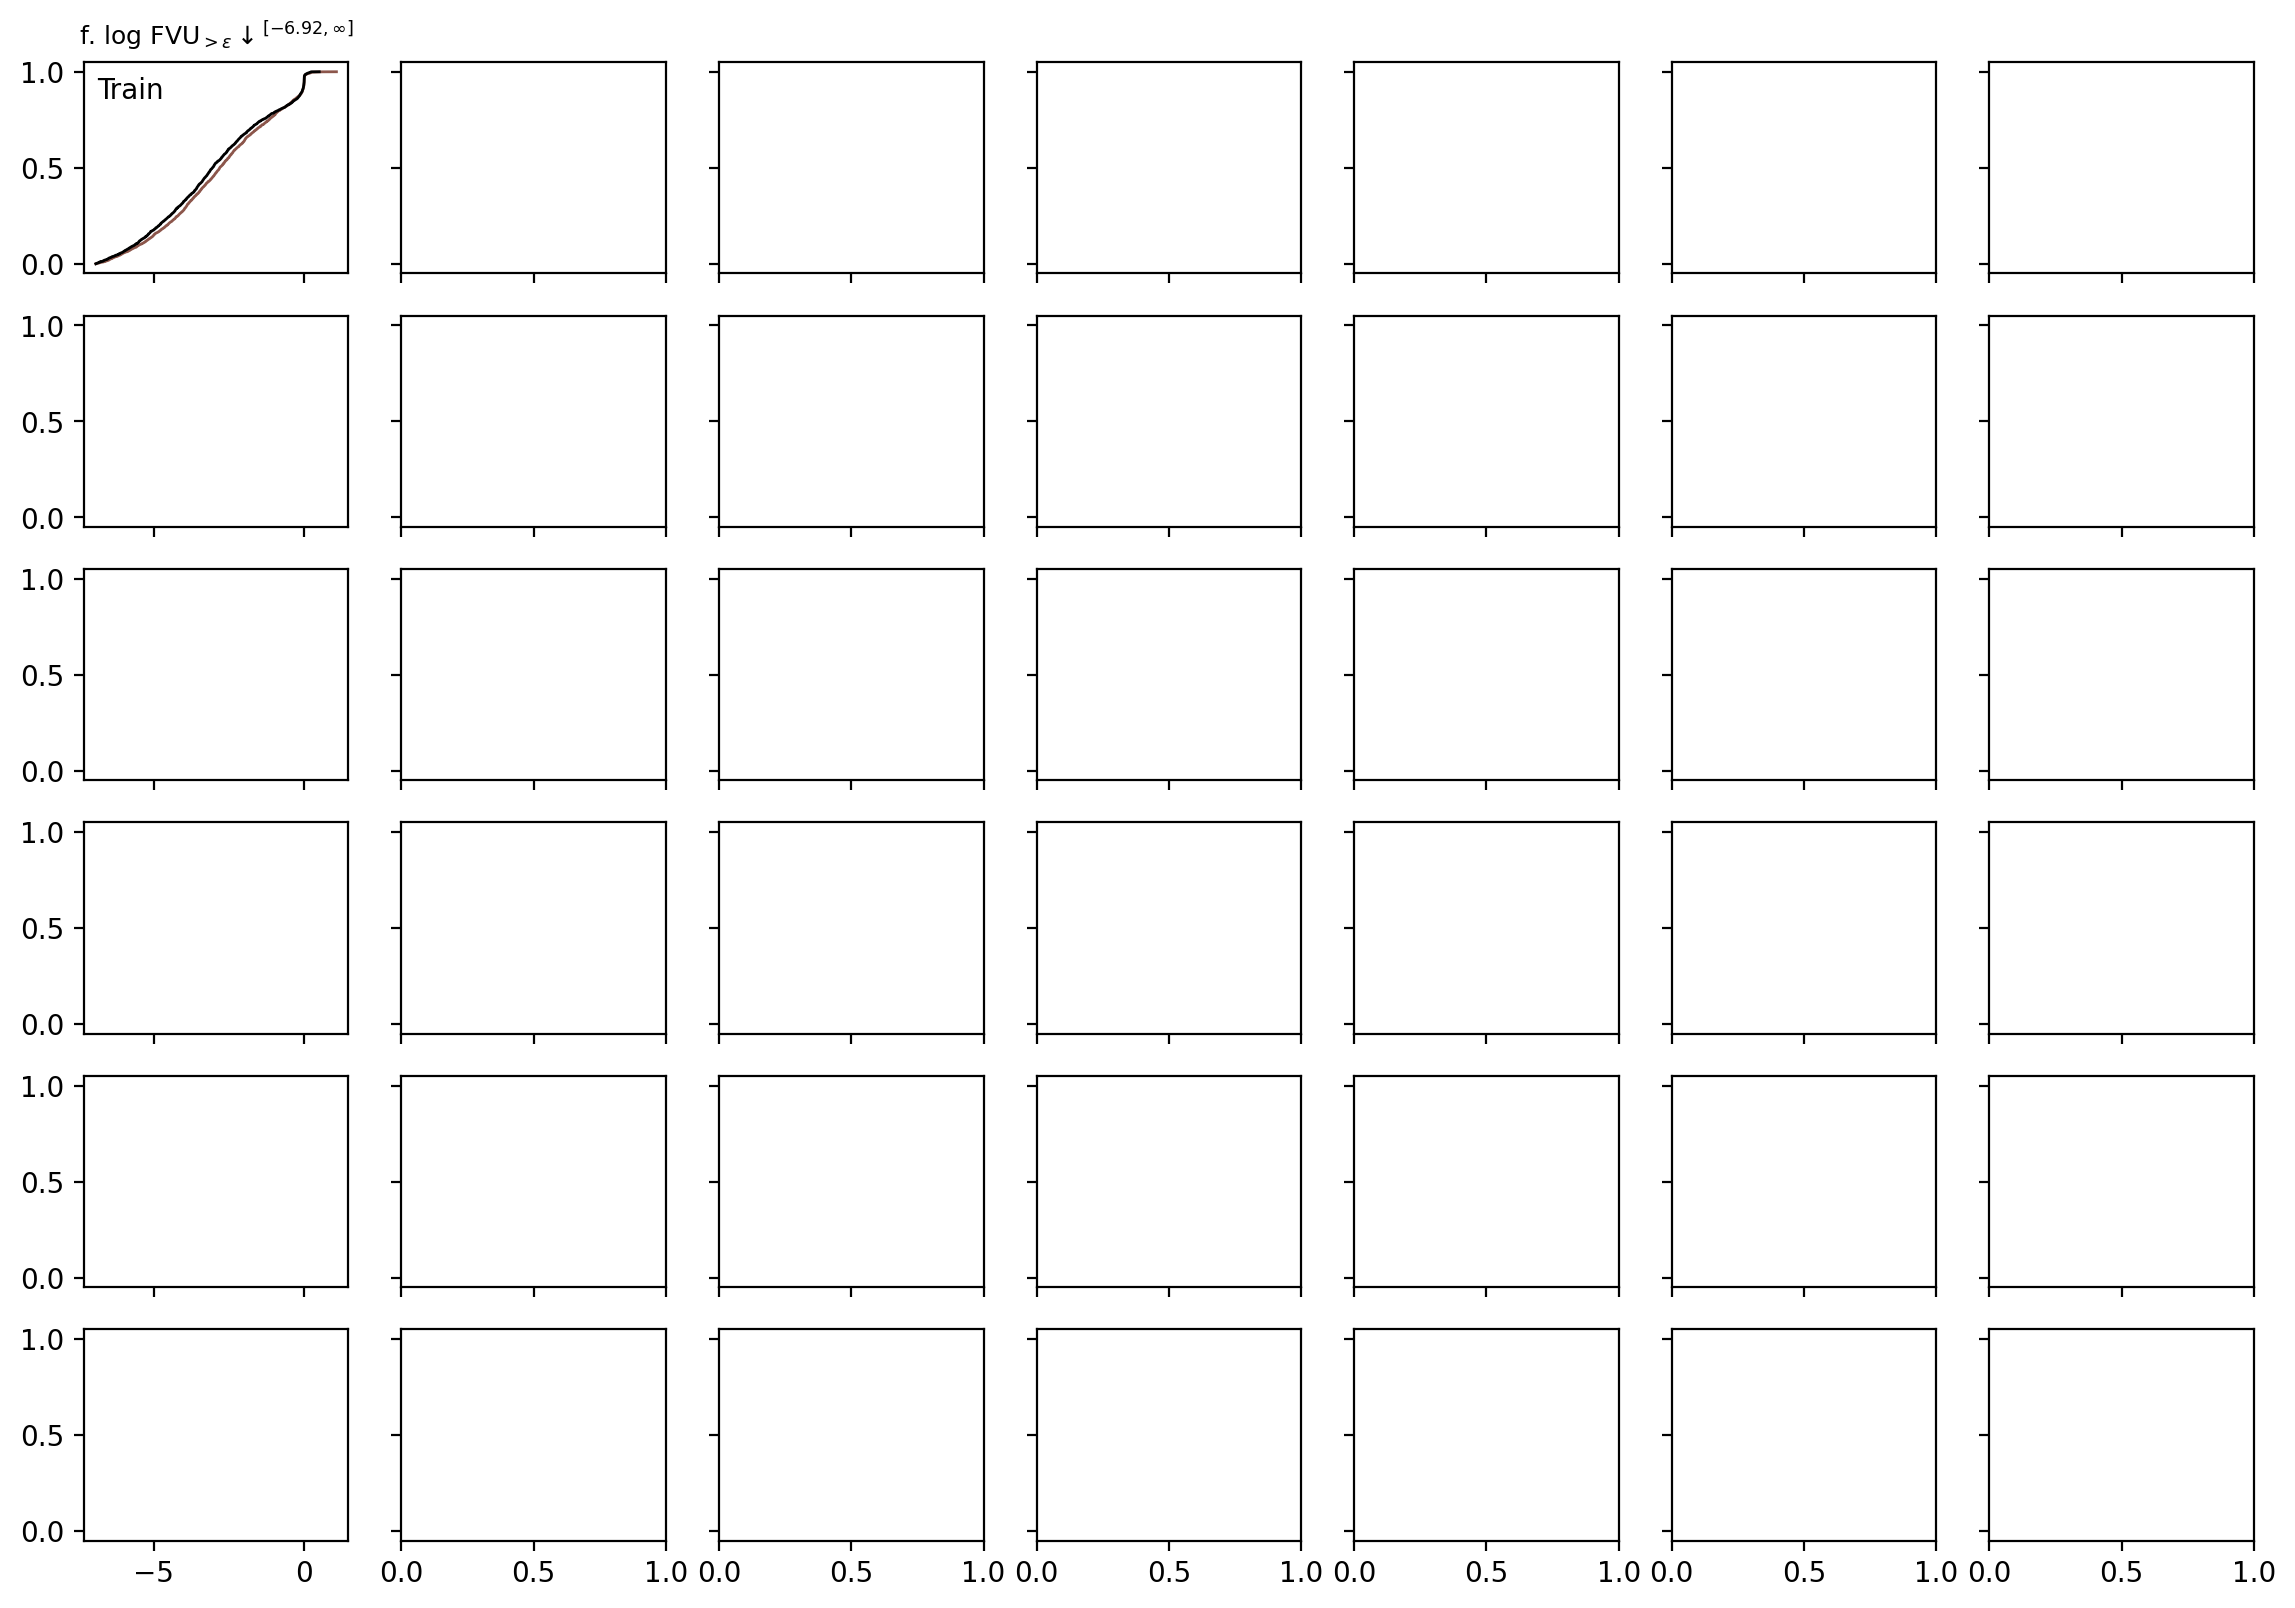

In [64]:
showcase_columns = ['log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'tree_edit_distance_best_beam', 'perplexity', 'f1_score_best_beam', 'reciprocal_rank', 'wall_time']
xlims = [(-7, 3), (-7, 3), (0, 64), (1, 256), (0, 1), (0, 1), (1/8, 512)]
scale = ('linear', 'linear', 'linear', 'log', 'linear', 'linear', 'log')

metric_aliases = {
    "log_fvu_not_epsilon": '$\\text{f. log FVU}_{> \epsilon}\\downarrow^{[' + f'{np.log10(np.finfo(np.float32).eps):.2f}' + r', \infty]}$',
    "log_fvu_not_epsilon_val": '$\\text{v. log FVU}_{> \epsilon}\\downarrow^{[' + f'{np.log10(np.finfo(np.float32).eps):.2f}' + r', \infty]}$',
    "tree_edit_distance_best_beam":	'$\\text{ZSS}\\downarrow^{[0, \infty]}$',
    "perplexity": '$\\text{PPL}\\downarrow^{[1, \infty]}$',
    "f1_score_best_beam": '$\\text{F1}\\uparrow^{[0, 1]}$',
    "reciprocal_rank": '$\\text{MRR}\\uparrow^{[0, 1]}$',
    "wall_time": '$\\text{T}_\\text{wall}\\downarrow^{[0, \infty]}$',
}

model_aliases_latex = {
    'pysr': 'PySR',
    'nesymres-100M': 'NeSymReS 100M',
    'v7.0': 'v7.0: Base',
    'v7.0-mini': 'v7.0-mini: 2.7M P.',
    'v7.11': 'v7.11: $N_\\text{ops} \\leq 15$',
    'v7.12': 'v7.12: $D \\leq 11$',
    'v7.20': 'v7.20: Auto Simplify',
    'v8.0': 'v8.0: with $\\mathcal{L}_\\text{CE}$',
    'v9.0': 'v9.0: 50% CC',
    'v9.1': 'v9.1: 100% CC',
}

model_colors = {
    'pysr': '#c13345',
    'nesymres-100M': '#979073',
    'v7.0': 'k',
    'v7.0-mini': '#20C9B6',
    'v7.11': 'tab:orange',
    'v7.12': 'tab:blue',
    'v7.20': 'tab:green',
    'v8.0': 'tab:brown',
    'v9.0': 'tab:purple',
    'v9.1': 'tab:pink',
}

ROWS = len(TEST_SET_TITLES)
COLS = len(showcase_columns)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 1.6), dpi=200, sharey=True, sharex='col')

for row, test_set in enumerate(TEST_SET_TITLES):
    axes[row, 0].annotate(f'{TEST_SET_TITLES[test_set]}', xy=(0.05, 0.93), xycoords='axes fraction', ha='left', va='top', color='k')
    for col, column in enumerate(showcase_columns):
        axes[0, col].set_title(metric_aliases.get(column, column), fontsize=9)
        for model, model_dfs in array_dfs.items():
            if test_set not in model_dfs:
                continue
            test_set_dfs = model_dfs[test_set]
            if column not in test_set_dfs.columns:
                continue
            valid_mask = np.isfinite(test_set_dfs[column].values)
            cdf_values = np.linspace(0, 1, valid_mask.sum())
            axes[row, col].plot(np.sort(test_set_dfs[column].values[valid_mask]), cdf_values, zorder=2 if model == 'v7.0' else 1, color=model_colors[model], linewidth=1)
        axes[row, col].set_xlim(xlims[col])
        axes[row, col].set_xscale(scale[col])
        axes[row, col].set_ylim(0, 1)
        axes[row, col].grid(alpha=0.2)

# Add a legend to the first subplot
for model in list(model_colors.keys())[:5]:
    axes[0, -1].plot([], [], label=model_aliases_latex[model], color=model_colors[model], linewidth=1.5)
axes[0, -1].legend(loc='lower right', fontsize=6, frameon=False)

# Add a legend to the first subplot
for model in list(model_colors.keys())[5:]:
    axes[1, -1].plot([], [], label=model_aliases_latex[model], color=model_colors[model], linewidth=1.5)
axes[1, -1].legend(loc='lower right', fontsize=6, frameon=False)

fig.tight_layout()

plt.savefig(get_path('results', 'main', create=True, filename='CDFs_2.svg'), bbox_inches='tight')